In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### The first part of the form has 3 questions for each pair of stanzas.  
#### The second part of the form has 2 question for each stanza

# Collect annotations for pairwise comparisons

In [2]:
def get_pairwise_annotation_df(form_csv_path, source_tsv_path):
    df = pd.read_csv(form_csv_path)
    df = df.T
    
    source_df = pd.read_csv(source_tsv_path, sep="\t")
    source_df["order_in_pair"] = [1,2]*(len(source_df)//2)
    written_by_human = source_df.loc[source_df["type"]=="orig"].order_in_pair
    
    choose_human_prompt = "Hvilket vers er skrevet av et menneske?"
    rhymes_v1 = "Er vers 1 skrevet på rim?"
    rhymes_v2 = "Er vers 2 skrevet på rim?"

    rated_human = []
    rhyme_rating = []    

    for i, gold in enumerate(written_by_human):
        human_s = choose_human_prompt
        v1_s = rhymes_v1
        v2_s = rhymes_v2
        if i:
            human_s += f".{i}"
            v1_s += f".{i}"
            v2_s += f".{i}"

        orig_rated_human = df.loc[human_s]
        orig_rated_human = [int(e.split()[1])==gold for e in orig_rated_human]

        rhyme_v1 = list(df.loc[v1_s].apply(int))
        rhyme_rating.append(rhyme_v1)

        rhyme_v2 = list(df.loc[v2_s].apply(int))
        rhyme_rating.append(rhyme_v2)


        i = i*2
        if source_df.loc[i].type == "orig":
            rated_human.append(orig_rated_human)
            rated_human.append([not(e) for e in orig_rated_human])
        else:
            rated_human.append([not(e) for e in orig_rated_human])
            rated_human.append(orig_rated_human)


    source_df["rated_human"] = rated_human
    source_df["rhyme_rating"] = rhyme_rating
    return source_df

# Collect annotations for standalone verses 

In [3]:
def get_standalone_annotation_df(form_csv_path, source_tsv_path):
    df = pd.read_csv(form_csv_path)
    df = df.T
    
    source_df = pd.read_csv(source_tsv_path, sep="\t")
    rhymes_q = "Er verset skrevet på rim?"
    human_q = "Er verset skrevet av et menneske?"

    rated_human = []
    rhyme_rating = []    

    for i in range(len(source_df)):
        human_s = human_q
        rhymes_s = rhymes_q
        if i:
            human_s += f".{i}"
            rhymes_s += f".{i}"

        rated_human.append([e=="Ja" for e in df.loc[human_s]])
        rhyme_rating.append(list(df.loc[rhymes_s].apply(int))) 

    source_df["rated_human"] = rated_human
    source_df["rhyme_rating"] = rhyme_rating

    return source_df

# Summary 

In [4]:
def get_avg_rhyme_rating(df):
    return round(np.mean([n for e in df["rhyme_rating"] for n in e]), 2)

def get_rated_human_percentage(df, not_human=False):
    rated = [e for l in df["rated_human"] for e in l]
    if not_human:
        return round(np.mean([not(e) for e in rated])*100, 2)
    return round(np.mean(rated)*100, 2)

# Look at results

In [5]:
side_by_side_df = pd.DataFrame({})
standalone_df = pd.DataFrame({})

for i in range(1, 5):
    df = get_pairwise_annotation_df(f"annotations/Evaluering av AI-genererte dikt og rim {i}.csv",
                                   f"side_by_side_form_{i}.tsv")
    df["form_number"] = [i]*len(df)
    side_by_side_df = pd.concat([side_by_side_df, df])
    
    df = get_standalone_annotation_df(f"annotations/Evaluering av AI-genererte dikt og rim {i}.csv",
                                     f"rest_{i}.tsv")
    df["form_number"] = [i]*len(df)
    standalone_df = pd.concat([standalone_df, df])

In [6]:
standalone_df

,Unnamed: 0,type,scheme,stanza,rated_human,rhyme_rating,form_number
0,5,line,ABCB,med yndig majestet han går \n som gjorde sinn...,"[False, True, True, False, False, False, True]","[3, 3, 3, 3, 3, 2, 3]",1
1,3,orig,AAB,hva er det for et mektig lys\ndet farer som et...,"[True, True, False, True, True, True, True]","[2, 3, 3, 2, 2, 2, 2]",1
2,4,orig,AABB,skurken saulus løfter armen\natter dette stikk...,"[True, True, False, False, True, True, False]","[3, 3, 3, 3, 3, 3, 3]",1
3,0,orig,ABCCAB,frysende skinner det store og sanne\nvarme har...,"[True, False, False, False, True, True, True]","[2, 3, 3, 3, 3, 2, 2]",1
4,15,base,-,og til han far elsket sønn så fordum lystig v...,"[True, False, False, False, False, False, False]","[3, 3, 3, 2, 2, 1, 2]",1
...,...,...,...,...,...,...,...
15,9,line,ABABCC,skjønt hver av dem er kraftig som en hest \n ...,"[False, True, False, False, False, True]","[2, 2, 2, 2, 2, 2]",4
16,19,base,-,hvor vred ble det kryp i sne \n som bølger i ...,"[True, False, False, True, True, False]","[1, 1, 1, 1, 3, 1]",4
17,18,base,-,ta dem dog av meg selv \n over denne dag jeg ...,"[False, False, False, False, False, False]","[0, 0, 0, 0, 0, 0]",4
18,7,line,ABABCC,og enda ser a ut som a var bare skinn og bein...,"[False, True, False, True, True, True]","[3, 3, 3, 3, 3, 2]",4


In [7]:
side_by_side_df

,Unnamed: 0,type,scheme,stanza,pair_number,order_in_pair,rated_human,rhyme_rating,form_number
0,20,stanza,ABAB,her hørte dalen her så det seg svang \n runde...,0,1,"[False, False, True, False, False, False, False]","[3, 3, 2, 3, 3, 1, 3]",1
1,0,orig,AABCCB,sjo-i sjo-i hyss\nsang jeg om et kyss\nnei det...,0,2,"[True, True, False, True, True, True, True]","[3, 3, 3, 3, 3, 3, 3]",1
2,1,orig,ABAB,du den høyeste blandt høye\ndu den viseste bla...,1,1,"[True, True, False, False, True, True, True]","[3, 3, 3, 3, 3, 3, 3]",1
3,18,line,ABAB,inn i fjellets flammesky \n en lovsangs brus ...,1,2,"[False, False, True, True, False, False, False]","[3, 3, 3, 3, 3, 0, 3]",1
4,16,line,ABAB,landets fiender og dro \n la min unge søsters...,2,1,"[False, True, True, False, False, False, False]","[3, 3, 3, 3, 3, 1, 3]",1
...,...,...,...,...,...,...,...,...,...
25,27,base,-,jeg er død som en byrde i mørket lyser \n og ...,12,2,"[True, False, False, False, True, False]","[0, 0, 0, 0, 0, 0]",4
26,13,orig,ABAB,for henne selv ble livet nu\nen natt hvor inge...,13,1,"[True, True, True, True, True, True]","[3, 3, 3, 3, 3, 3]",4
27,28,base,-,ti falt ei het og vill \n av byens siste natt...,13,2,"[False, False, False, False, False, False]","[0, 0, 0, 0, 0, 0]",4
28,14,orig,AABB,å nå forstår jeg det var ham\njeg drømte om de...,14,1,"[True, True, True, True, True, True]","[3, 3, 3, 3, 3, 3]",4


In [8]:
base = side_by_side_df.loc[side_by_side_df["type"]=="base"]
line = side_by_side_df.loc[side_by_side_df["type"]=="line"]
stanza = side_by_side_df.loc[side_by_side_df["type"]=="stanza"] 
orig = side_by_side_df.loc[side_by_side_df["type"]=="orig"] 

print(f"""
PAIRWISE ratings results:
    Original stanzas:
        Average rhyme rating                   : {get_avg_rhyme_rating(orig)}
        % of times rated 'written by a human'  : {get_rated_human_percentage(orig)}
    
    Baseline generation:
        Average rhyme rating                   : {get_avg_rhyme_rating(base)}
        % of times rated 'written by a human'  : {get_rated_human_percentage(base)}
    
    Line-level generation:
        Average rhyme rating                   : {get_avg_rhyme_rating(line)}
        % of times rated 'written by a human'  : {get_rated_human_percentage(line)}
        
    Stanza-level generation:
        Average rhyme rating                   : {get_avg_rhyme_rating(stanza)}
        % of times rated 'written by a human'  : {get_rated_human_percentage(stanza)}
""")


PAIRWISE ratings results:
    Original stanzas:
        Average rhyme rating                   : 2.61
        % of times rated 'written by a human'  : 85.19
    
    Baseline generation:
        Average rhyme rating                   : 0.61
        % of times rated 'written by a human'  : 19.26
    
    Line-level generation:
        Average rhyme rating                   : 2.33
        % of times rated 'written by a human'  : 17.78
        
    Stanza-level generation:
        Average rhyme rating                   : 2.02
        % of times rated 'written by a human'  : 7.41



In [9]:
base = standalone_df.loc[standalone_df["type"]=="base"]
line = standalone_df.loc[standalone_df["type"]=="line"]
stanza = standalone_df.loc[standalone_df["type"]=="stanza"] 
orig = standalone_df.loc[standalone_df["type"]=="orig"] 

print(f"""
STANDALONE ratings results:
    Original stanzas:
        Average rhyme rating                   : {get_avg_rhyme_rating(orig)}
        % of times rated 'written by a human'  : {get_rated_human_percentage(orig)}
    
    Baseline generation:
        Average rhyme rating                   : {get_avg_rhyme_rating(base)}
        % of times rated 'written by a human'  : {get_rated_human_percentage(base)}
    
    Line-level generation:
        Average rhyme rating                   : {get_avg_rhyme_rating(line)}
        % of times rated 'written by a human'  : {get_rated_human_percentage(line)}
        
    Stanza-level generation:
        Average rhyme rating                   : {get_avg_rhyme_rating(stanza)}
        % of times rated 'written by a human'  : {get_rated_human_percentage(stanza)}
""")


STANDALONE ratings results:
    Original stanzas:
        Average rhyme rating                   : 2.68
        % of times rated 'written by a human'  : 82.96
    
    Baseline generation:
        Average rhyme rating                   : 0.91
        % of times rated 'written by a human'  : 25.19
    
    Line-level generation:
        Average rhyme rating                   : 2.2
        % of times rated 'written by a human'  : 48.89
        
    Stanza-level generation:
        Average rhyme rating                   : 1.79
        % of times rated 'written by a human'  : 11.11



In [10]:
total_df = pd.concat([standalone_df, side_by_side_df])

base = total_df.loc[total_df["type"]=="base"]
line = total_df.loc[total_df["type"]=="line"]
stanza = total_df.loc[total_df["type"]=="stanza"] 
orig = total_df.loc[total_df["type"]=="orig"] 

print(f"""
COMBINED ratings results:
    Original stanzas:
        Average rhyme rating                   : {get_avg_rhyme_rating(orig)}
        % of times rated 'written by a human'  : {get_rated_human_percentage(orig)}
    
    Baseline generation:
        Average rhyme rating                   : {get_avg_rhyme_rating(base)}
        % of times rated 'written by a human'  : {get_rated_human_percentage(base)}
    
    Line-level generation:
        Average rhyme rating                   : {get_avg_rhyme_rating(line)}
        % of times rated 'written by a human'  : {get_rated_human_percentage(line)}
        
    Stanza-level generation:
        Average rhyme rating                   : {get_avg_rhyme_rating(stanza)}
        % of times rated 'written by a human'  : {get_rated_human_percentage(stanza)}
""")


COMBINED ratings results:
    Original stanzas:
        Average rhyme rating                   : 2.63
        % of times rated 'written by a human'  : 84.63
    
    Baseline generation:
        Average rhyme rating                   : 0.76
        % of times rated 'written by a human'  : 22.22
    
    Line-level generation:
        Average rhyme rating                   : 2.27
        % of times rated 'written by a human'  : 33.33
        
    Stanza-level generation:
        Average rhyme rating                   : 1.91
        % of times rated 'written by a human'  : 9.26



# Find most controversial stanzas

In [11]:
def rhyme_controversial_stanzas(df, threshold=3):
    
    def above_threshold(ratings):
        ma = max(ratings)
        mi = min(ratings)
        return ma-mi
    
    df = df.copy()   
    df["rhyme_diff"] = df.rhyme_rating.apply(above_threshold)
    
    return df.loc[df["rhyme_diff"]>=threshold]

def human_controversial(df, threshold=3):
    
    def count_true_ratings(ratings):
        return sum(ratings)
    
    def count_false_ratings(ratings):
        c_true = count_true_ratings(ratings)
        c_false = len(ratings)-c_true
        return c_false
    
    df = df.copy()
    df["count_human"] = df.rated_human.apply(count_true_ratings)
    df["count_not_human"] = df.rated_human.apply(count_false_ratings)
    return df.loc[(df["count_human"] >= threshold) & (df["count_not_human"] >= threshold)]

In [21]:
rh_con = rhyme_controversial_stanzas(total_df)
                                    
print(len(rh_con))

for e in rh_con.itertuples():
    print(e.rhyme_rating)
    print(e.type)
    print(e.stanza)
    print("--\n")

19
[3, 2, 0, 2, 2, 1, 2]
stanza
 hvor bårer med skum over utsteinen slår 
 og kjølens siste bakker i det kildested 
 det første hender med høstens redsler død 
 hin yngste apall strør blikke hevet goder tå flyver ned 
--

[3, 2, 3, 2, 2, 0, 3]
orig
da lyner et lys ned i dypet
en gnistrende sprøyt av ild
det glitrer av blånende bølger
er havet likevel til
--

[2, 1, 3, 1, 1, 0, 1]
base
 så stolt som sus av ført over vannet 
 bak litt av hundre om fabrikk 
 steg opp av deres dyp var plass 
 som vrak på femti favne 
 
 
--

[2, 1, 3, 2, 2, 0, 2]
line
 der sisler stekepanner fylt med flesk og småmakrell 
 der sitter på fluberget tusner av fugl 
 menn og kvinner tatt i ed 
 der er rom hans lengsels mål og med 
--

[3, 2, 1, 1, 0, 0, 2]
line
 alene mot tuseners raseri 
 de onde omringer mitt leie 
 og klokker med gullplateklang 
 alt er nå blitt fryd og lyst 
 vekker landets storhet noen gjenklang i hans bryst 
 tro som en sang 
--

[3, 2, 2, 0, 2, 1, 3]
orig
til oppbrudd blir allting gjort 

In [20]:
h_con = human_controversial(total_df)

print(len(h_con))

for e in h_con.itertuples():
    print(e.rated_human)
    print("actual type:", e.type)
    print("--")
    print(e.stanza)
    print("--\n")

25
[False, True, True, False, False, False, True]
actual type: line
--
 med yndig majestet han går 
 som gjorde sinnet blått av romantikk 
 vansiret av laster sykdom og sår 
 plutselig stod stauper igjen for mitt blikk 
--

[True, True, False, False, True, True, False]
actual type: orig
--
skurken saulus løfter armen
atter dette stikk i barmen
denne angst de syner røde
taus han stirrer på den døde
--

[True, False, False, False, True, True, True]
actual type: orig
--
frysende skinner det store og sanne
varme har titt klekket øgler av nid
du dødning deroppe sumpen er lunken
hat er på jorden himlen er sunken
så merk da med offerets islys vår panne
rid rytter rid
--

[False, False, True, True, False, False, True]
actual type: base
--
 på abel-meholas marker 
 i harpen i favn 
 og spiller 
 i skjebnens skjulte ro 
 hvorfor vil jeg deg til gavn 
 o når du er det tvilen er din tilflukt 
 i hvert hjerte ligger der 
 
 
--

[True, False, False, False, True, False, True]
actual type: stanza
--


# Find original stanzas rated 'not human'

In [14]:
orig = total_df.loc[total_df["type"]=="orig"].copy()

def avg_rating(ratings):
    s = sum(ratings)
    return s/len(ratings)

orig["avg_human_rating"] = orig.rated_human.apply(avg_rating)
hu = orig.loc[orig["avg_human_rating"]<=0.5]
for e in hu.itertuples():
    print(e.rated_human)
    print(e.scheme)
    print(e.stanza)
    print("--\n")

[False, False, False, False, True, True, False]
ABAB
tillykke med dåden dere frelste imperiet
mac donald og thomas og henderson
og jobben var hård dere fortjener en ferie
men først må dere kysse hr. baldwins hånd
--

[False, False, True, False, True, True, False]
AABB
det følte hver som kom
fra reis igjen og så seg om
det følte hver som gikk
i siste avskjedsblikk
--

[False, True, True, False, True, False, False]
ABCDCB
å våke over fedrelandets lover
å sørge for at ingenting forlises
er smukt betryggende for folkehellet
men det er skjønnere med ånd å våge
å slå med moses tryllestav på fjellet
skjønt nytten ei kan fattes og bevises
--



In [28]:
hu

,Unnamed: 0,type,scheme,stanza,rated_human,rhyme_rating,form_number,pair_number,order_in_pair,avg_human_rating
7,3,orig,ABAB,tillykke med dåden dere frelste imperiet\nmac ...,"[False, False, False, False, True, True, False]","[2, 3, 3, 2, 2, 1, 0]",1,3.0,2.0,0.285714
14,7,orig,AABB,det følte hver som kom\nfra reis igjen og så s...,"[False, False, True, False, True, True, False]","[3, 3, 3, 3, 3, 3, 3]",2,7.0,1.0,0.428571
17,8,orig,ABCDCB,å våke over fedrelandets lover\nå sørge for at...,"[False, True, True, False, True, False, False]","[2, 3, 2, 2, 2, 2, 2]",3,8.0,2.0,0.428571


In [27]:
for f, p in zip(hu.form_number, hu.pair_number):
    s = side_by_side_df.loc[(side_by_side_df.form_number == f) & (side_by_side_df.pair_number == p)]
    for e in s.itertuples():
        print(e.rhyme_rating)
        print(e.type)
        print(e.rated_human)
        print(e.stanza)
        print("")
    print("___________________--___________________")

[2, 3, 3, 2, 2, 1, 1]
line
[True, True, True, True, False, False, True]
 han er jo 
 hva var det en guds fiolin 
 templet du har skjendet med vold og blod 
 især i det siste de trenger seg inn 

[2, 3, 3, 2, 2, 1, 0]
orig
[False, False, False, False, True, True, False]
tillykke med dåden dere frelste imperiet
mac donald og thomas og henderson
og jobben var hård dere fortjener en ferie
men først må dere kysse hr. baldwins hånd

___________________--___________________
[3, 3, 3, 3, 3, 3, 3]
orig
[False, False, True, False, True, True, False]
det følte hver som kom
fra reis igjen og så seg om
det følte hver som gikk
i siste avskjedsblikk

[3, 3, 2, 1, 1, 1, 3]
line
[True, True, False, True, False, False, True]
 sjelevingens hvilegren 
 har båret det ord og det ble igjen 
 frem stormer egyptens armé 
 et dryssende stjernegry 
 fra sinnet på ny og på ny 
 hans veier ble lys for lys og fred 

___________________--___________________
[0, 1, 0, 0, 0, 0, 1]
base
[True, False, False, True, False

## Plot rhyme ratings

In [16]:
def get_rhyme_ratings_counts(type_):
    ratings = list(standalone_df.loc[standalone_df["type"]==type_].rhyme_rating) + list(side_by_side_df.loc[side_by_side_df["type"]==type_].rhyme_rating)
    flat_ratings = [r for rates in ratings for r in rates]
    return Counter(flat_ratings)

c_base = get_rhyme_ratings_counts("base")
c_line = get_rhyme_ratings_counts("line")
c_stanza = get_rhyme_ratings_counts("stanza")
c_orig =  get_rhyme_ratings_counts("orig")

In [17]:
base = sorted(list(c_base.items()), key=lambda x: x[0])
line = sorted(list(c_line.items()), key=lambda x: x[0])
stanza = sorted(list(c_stanza.items()), key=lambda x: x[0])
orig = sorted(list(c_orig.items()), key=lambda x: x[0])

line = [(_, c/sum(c_line.values())*100) for _, c in line]
base = [(_, c/sum(c_base.values())*100) for _, c in base]
stanza = [(_, c/sum(c_stanza.values())*100) for _, c in stanza]
orig = [(_, c/sum(c_orig.values())*100) for _, c in orig]

In [18]:
labels, base_counts = zip(*base)
_, line_counts = zip(*line)
_, stanza_counts = zip(*stanza)
_, orig_counts = zip(*orig)

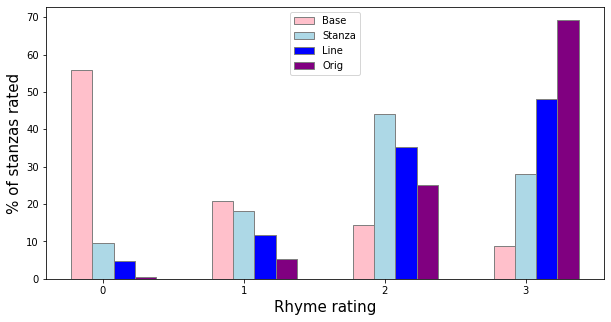

In [19]:
fig, ax = plt.subplots(figsize=(10,5))

barWidth = 0.15

# Set position of bar on X axis
br1 = np.arange(len(labels))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# Make the plot
plt.bar(br1, base_counts, color ='pink', width = barWidth,
        edgecolor ='grey', label ='Base')
plt.bar(br2, stanza_counts, color ='lightblue', width = barWidth,
        edgecolor ='grey', label ='Stanza')
plt.bar(br3, line_counts, color ='b', width = barWidth,
        edgecolor ='grey', label ='Line')
plt.bar(br4, orig_counts, color ='purple', width = barWidth,
        edgecolor ='grey', label ='Orig')

plt.xlabel('Rhyme rating', fontsize = 15)
plt.ylabel('% of stanzas rated', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(labels))], labels)
 
plt.legend()
plt.show()

In [26]:
for e in total_df.loc[total_df.type == "stanza"].itertuples():
    print(e.rhyme_rating)
    print(e.stanza)
    print(e.form_number)
    print("")

[3, 2, 0, 2, 2, 1, 2]
 hvor bårer med skum over utsteinen slår 
 og kjølens siste bakker i det kildested 
 det første hender med høstens redsler død 
 hin yngste apall strør blikke hevet goder tå flyver ned 
1

[2, 2, 3, 2, 2, 1, 2]
 vel fiolin 
 jeg satt med i varme hud 
 men stod under vold og fred 
 og maktet skjold hadde prisen gud 
1

[2, 2, 2, 2, 2, 1, 2]
 opp jeg bygge grensen bered 
 frossen fred 
 og lang er av prøvesten 
 bak arne ring gikk på høyens atten 
1

[2, 2, 2, 2, 2, 0, 2]
 nuets underveis 
 se det er det jovisst 
 der ligger så stille mot vest hvor sol går ned 
 som klippene og sluttet kvist 
1

[2, 2, 1, 2, 2, 0, 2]
 og følge i ro av savn ildstråleflor 
 hvor jeg spør deg han skjønnere skal storm 
 o gud og lenge lyse søstersønn 
 spredt jord og slappe slappe stæders trollmann krigerby vande vandringsmann beklemt lyster utsikt lønn 
1

[1, 0, 0, 0, 0, 0, 1]
 det mørkner det legems klare hjerne 
 den sløyer og slynger seg om stolt og om mast 
 langs berget de modig 